In [1]:
import jax
import jax.numpy as jnp
import haiku as hk

from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct, core
import optax

import jax_dataloader as jdl


from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import json
import numpy as np

from typing import Callable, Any, List

import torch, torchvision
from torchvision import transforms

from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import glob
from typing import List, Dict, Tuple
from dataclasses import dataclass

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Build DARTS cell on Haiku

Useful example: https://github.com/deepmind/dm-haiku/blob/main/examples/transformer/model.py


## OPS

In [3]:
class DropPath(hk.Module):
    def __init__(self, p=0.0):
        super().__init__()
        self.p = p

    def __call__(self, x, is_training=False):
        if is_training and self.p > 0:
            keep_p = 1.0 - self.p
            mask = jax.random.bernoulli(hk.next_rng_key(), keep_p, (x.shape[0], 1, 1, 1))
            return x / keep_p * mask
        return x


class Identity(hk.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, x, is_training=False):
        return x


class PoolBN(hk.Module):
    def __init__(self, pool_type, kernel_size, stride, affine=True):  # C is not needed
        super().__init__()
        if pool_type.lower() == 'max':
            self.pool = hk.MaxPool(window_shape=kernel_size, strides=stride, padding='SAME')
        elif pool_type.lower() == 'avg':
            self.pool = hk.AvgPool(window_shape=kernel_size, strides=stride, padding='SAME') # TODO: count_include_pad=False
        else:
            raise ValueError()
        self.bn = hk.BatchNorm(affine, affine, 0.9)

    def __call__(self, x, is_training):
        out = self.pool(x)
        out = self.bn(out, is_training)
        return out


class StdConv(hk.Module):
    def __init__(self, C_out, kernel_size, stride, affine=True):  # C_in is not needed
        super().__init__()
        self.conv = hk.Conv2D(C_out, kernel_shape=kernel_size, stride=stride,
                              padding='SAME', with_bias=False)
        self.bn = hk.BatchNorm(affine, affine, 0.9)

    def __call__(self, x, is_training):
        out = jax.nn.relu(x)
        out = self.conv(out)
        out = self.bn(out, is_training)
        return out


class FacConv(hk.Module):
    """
    Factorized conv: ReLU - Conv(Kx1) - Conv(1xK) - BN
    """
    def __init__(self, C_in, C_out, kernel_length, stride, affine=True):
        super().__init__()
        self.conv1 = hk.Conv2D(C_in, kernel_shape=(kernel_length, 1), stride=stride, padding='SAME',
                              with_bias=False)
        self.conv2 = hk.Conv2D(C_out, kernel_shape=(1, kernel_length), stride=stride, padding='SAME',
                               with_bias=False)
        self.bn = hk.BatchNorm(affine, affine, 0.9)
        
    def __call__(self, x, is_training):
        out = jax.nn.relu(x)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.bn(out, is_training)
        return out


class DilConv(hk.Module):
    """
    (Dilated) depthwise separable conv.
    ReLU - (Dilated) depthwise separable - Pointwise - BN.
    If dilation == 2, 3x3 conv => 5x5 receptive field, 5x5 conv => 9x9 receptive field.
    """
    def __init__(self, C_in, C_out, kernel_size, stride, dilation, affine=True):
        super().__init__()
        self.conv1 = hk.Conv2D(C_in, kernel_shape=kernel_size, stride=stride, rate=dilation,
                               padding='SAME', with_bias=False)
        self.conv2 = hk.Conv2D(C_out, kernel_shape=1, stride=1, rate=dilation,
                               padding='SAME', with_bias=False)
        self.bn = hk.BatchNorm(affine, affine, 0.9)
        
    def __call__(self, x, is_training):
        out = jax.nn.relu(x)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.bn(out, is_training)
        return out


class SepConv(hk.Module):
    """
    Depthwise separable conv.
    DilConv(dilation=1) * 2.
    """
    def __init__(self, C_in, C_out, kernel_size, stride, affine=True):
        super().__init__()
        self.conv1 = DilConv(C_in, C_out, kernel_size, stride, 1, affine)
        self.conv2 = DilConv(C_in, C_out, kernel_size, 1, 1, affine)

    def __call__(self, x, is_training):
        return self.conv2(self.conv1(x, is_training), is_training)
        

class FactorizedReduce(hk.Module):
    """
    Reduce feature map size by factorized pointwise (stride=2).
    """
    def __init__(self, C_out, affine=True):
        super().__init__()
        self.conv1 = hk.Conv2D(C_out // 2, kernel_shape=1, stride=2, padding='VALID', with_bias=False)
        self.conv2 = hk.Conv2D(C_out // 2, kernel_shape=1, stride=2, padding='VALID', with_bias=False)
        self.bn = hk.BatchNorm(affine, affine, 0.9)

    def __call__(self, x, is_training):
        out = jax.nn.relu(x)
        out = jnp.concatenate([self.conv1(out), self.conv2(out[:, 1:, 1:])], axis=-1)
        out = self.bn(out, is_training)
        return out
        
        
        
### TEST
def test_dp():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 2, 1, 1))
    dp = hk.transform(lambda x, is_training: DropPath(0.5)(x, is_training))
    params = dp.init(rng, x, True)
    assert dp.apply(params, rng, x, True).shape == x.shape


def test_id():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 2, 1, 1))
    id_ = hk.transform(lambda x, is_training: Identity()(x, is_training))
    params = id_.init(rng, x, True)
    assert id_.apply(params, None, x, True).shape == x.shape


def test_pool():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 16, 16, 3))
    pool = hk.transform_with_state(lambda x, is_t: PoolBN('avg', 3, 1)(x, is_t))
    params, state = pool.init(rng, x, True)
    assert pool.apply(params, state, rng, x, True)[0].shape == x.shape  # out, state_new = apply    


def test_std_conv():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 16, 16, 3))
    conv = hk.transform_with_state(lambda x, is_t: StdConv(3, 3, 1)(x, is_t))
    params, state = conv.init(rng, x, True)
    assert conv.apply(params, state, rng, x, True)[0].shape == x.shape  # out, state_new = apply

def test_fac_conv():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 16, 16, 3))
    conv = hk.transform_with_state(lambda x, is_t: FacConv(3, 3, 3, 1)(x, is_t))
    params, state = conv.init(rng, x, True)
    assert conv.apply(params, state, rng, x, True)[0].shape == x.shape  # out, state_new = apply 


def test_dil_conv():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    conv = hk.transform_with_state(lambda x, is_t: DilConv(16, 16, 5, 1, 2, False)(x, is_t))
    params, state = conv.init(rng, x, True)  # out, state_new = apply
    out = conv.apply(params, state, rng, x, True)[0]
    assert out.shape == x.shape, f'{out.shape}, {x.shape}'


def test_sep_conv():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    conv = hk.transform_with_state(lambda x, is_t: SepConv(16, 16, 3, 1)(x, is_t))
    params, state = conv.init(rng, x, True)
    assert conv.apply(params, state, rng, x, True)[0].shape == x.shape  # out, state_new = apply 


def test_fact_reduce():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 16, 16, 3))
    conv = hk.transform_with_state(lambda x, is_t: FactorizedReduce(4)(x, is_t))
    params, state = conv.init(rng, x, True)
    out = conv.apply(params, state, rng, x, True)[0]  # out, state_new = apply 
    assert out.shape == (3, 8, 8, 4), f'{out.shape}'



test_dp()
test_id()
test_pool()
test_std_conv()
test_fac_conv()
test_dil_conv()
test_sep_conv()
test_fact_reduce()


## Node

https://github.com/microsoft/nni/blob/master/examples/nas/legacy/oneshot/darts/model.py

See also an unresolved issue

https://stackoverflow.com/questions/76147761/train-multiple-nn-in-parallel-with-jax

In [33]:
class LayerChoice(hk.Module):
    def __init__(self, channels, stride, label='none'):
        super().__init__()
        self.label = label
        self.ops = [
            PoolBN('max', 3, stride, affine=False),
            PoolBN('avg', 3, stride, affine=False),
            Identity() if stride == 1 else FactorizedReduce(channels, False),
            SepConv(channels, channels, 3, stride, False),
            SepConv(channels, channels, 5, stride, False),
            DilConv(channels, channels, 3, stride, 2, False),
            DilConv(channels, channels, 5, stride, 2, False)
        ]
        self.op_names = ('maxpool', 'avgpool', 'skipconnect', 'sepconv3x3',
                         'sepconv5x5', 'dilconv3x3', 'dilconv5x5')
        
    def __call__(self, x, is_training):
        """x: (bs, w, h, c)"""
        alpha = hk.get_parameter("lc_alpha", shape=(len(self.ops),), init=hk.initializers.RandomNormal(1e-3))
        res = jnp.stack([op(x, is_training) for op in self.ops], axis=0)  # (# prev, bs, w, h, c)
        # res = hk.fori_loop(0, len(self.ops), lambda i, h: self._operation(i, h, is_training),
        #                    x[None].repeat(len(self.ops), axis=0))
        weights = jax.nn.softmax(alpha, axis=-1).reshape(-1, 1, 1, 1, 1)
        return (res * weights).sum(0)

    # def _operation(self, i, x_stack, is_training):
    #     """x from (prev, bs, *)"""
    #     # out = self.ops[self._id_to_op[i]](x_stack[i], is_training)  # (bs, *)
    #     out = hk.switch(i, self.ops, x_stack[i], is_training)
    #     return jnp.concatenate([x_stack[:i], out[None], x_stack[i + 1:]], axis=0)
        

class InputChoice(hk.Module):
    def __init__(self, n_cand: int, n_chosen: int, label='none'):
        super().__init__()
        self.n_chosen = n_chosen
        self.label = label
        self.n_cand = n_cand

    def __call__(self, inputs):
        alpha = hk.get_parameter("ic_alpha", shape=(self.n_cand,), dtype=jnp.float32,
                                 init=hk.initializers.RandomNormal(1e-3))
        inputs = jnp.stack(inputs, axis=0)  # (#cand, bs, w, h, c)
        weights = jax.nn.softmax(alpha, axis=-1).reshape(-1, 1, 1, 1, 1)
        return (inputs * weights).sum(0)


class Node(hk.Module):
    def __init__(self, node_id, num_prev_nodes, channels, num_downsample_connect, drop_path_prob):
        super().__init__()
        choice_keys = []
        self.edges = []
        for i in range(num_prev_nodes):
            stride = 2 if i < num_downsample_connect else 1
            choice_keys.append(f'{node_id}_p{i}')
            self.edges.append(LayerChoice(channels, stride, choice_keys[-1]))
        self.drop_path = DropPath(drop_path_prob)
        self.input_switch = InputChoice(n_cand=len(choice_keys), n_chosen=2, label=f'{node_id}_switch')

    def __call__(self, prev_nodes, is_training):
        """Prev nodes: List [bs, w, h, c]"""
        out = [self.drop_path(edge(node, is_training), is_training) \
               for edge, node in zip(self.edges, prev_nodes)]
        return self.input_switch(out)


### TEST
def test_layer_choice():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    lc = hk.transform_with_state(lambda x, is_t: LayerChoice(16, 1)(x, is_t))
    params, state = lc.init(rng, x, True)
    # print(params.keys())
    out = lc.apply(params, state, rng, x, True)[0]  # out, state_new = apply 
    assert out.shape == x.shape


def test_inp_choice():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    ic = hk.transform_with_state(lambda y: InputChoice(3, 2)(y))
    params, state = ic.init(rng, [x, x, x])
    out = ic.apply(params, state, rng, [x, x, x])[0]  # out, state_new = apply 
    assert out.shape == x.shape


def test_node():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    node = hk.transform_with_state(lambda x, t: Node(3, 3, 16, 0, 0.1)(x, t))
    params, state = node.init(rng, [x, x, x], True)
    out = node.apply(params, state, rng, [x, x, x], True)[0]
    assert out.shape == x.shape, f'{out.shape}'


test_layer_choice()
test_inp_choice()
test_node()

In [35]:
class Cell(hk.Module):
    def __init__(self, n_nodes, channels_pp, channels_p, channels, reduction_p, reduction, drop_path_prob):
        super().__init__()
        self.reduction = reduction
        self.n_nodes = n_nodes

        if reduction_p:
            self.preproc0 = FactorizedReduce(channels, affine=False)
        else:
            self.preproc0 = StdConv(channels, 1, 1, affine=False)
        self.preproc1 = StdConv(channels, 1, 1, affine=False)

        # generate dag
        self.mutable_ops = []
        for depth in range(2, self.n_nodes + 2):
            self.mutable_ops.append(Node(f"{'reduce' if reduction else 'normal'}_n{depth}",
                                         depth, channels, 2 if reduction else 0, drop_path_prob))

    def __call__(self, s0, s1, is_training):
        inputs = [self.preproc0(s0, is_training), self.preproc1(s1, is_training)]
        for node in self.mutable_ops:
            out = node(inputs, is_training)
            inputs.append(out)
        out = jnp.concatenate(inputs[2:], axis=-1)  # (bs, w, h, c * nodes)
        return out


def test_cell():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 16))
    cell = hk.transform_with_state(lambda x, y, t: Cell(4, 3*16, 3 * 16, 16, False, False, 0.1)(x, y, t))
    params, state = cell.init(rng, x, x, True)
    out = cell.apply(params, state, rng, x, x, True)[0]
    assert out.shape == (3, 32, 32, 64), f'{out.shape}'


test_cell()    

## CNN

In [36]:
class CNN(hk.Module):
    def __init__(self, channels, n_classes, n_layers, n_nodes=4,
                stem_multiplier=3, drop_path_prob=0.0):
        # TODO: add aux if necessary
        super().__init__()
        self.channels = channels
        self.n_classes = n_classes
        self.n_layers = n_layers
        c_cur = stem_multiplier * self.channels
        self.stem = hk.Conv2D(c_cur, 3, stride=1, padding='SAME', with_bias=False)
        self.stem_bn = hk.BatchNorm(True, True, 0.9)

        # for the first cell, stem is used for both s0 and s1
        # [!] channels_pp and channels_p is output channel size, but c_cur is input channel size.
        channels_pp, channels_p, c_cur = c_cur, c_cur, channels

        self.cells = []
        reduction_p, reduction = False, False
        for i in range(n_layers):
            reduction_p, reduction = reduction, False
            # Reduce featuremap size and double channels in 1/3 and 2/3 layer.
            if i in [n_layers // 3, 2 * n_layers // 3]:
                c_cur *= 2
                reduction = True
            cell = Cell(n_nodes, channels_pp, channels_p, c_cur, reduction_p, reduction, drop_path_prob)
            self.cells.append(cell)
            c_cur_out = c_cur * n_nodes
            channels_pp, channels_p = channels_p, c_cur_out
            
        self.linear = hk.Linear(n_classes)


    def __call__(self, x, is_training):
        s0 = s1 = self.stem_bn(self.stem(x), is_training)
        for i, cell in enumerate(self.cells):
            # cell(s0, s1)
            s0, s1 = s1, cell(s0, s1, is_training)

        out = s1.mean(axis=[-1, -2])  # global adaptive pooling
        out = out.reshape(out.shape[0], -1)  # flatten
        logits = self.linear(out)
        return logits

def test_cnn():
    rng = jax.random.PRNGKey(0)
    x = jnp.ones((3, 32, 32, 3))
    cnn = hk.transform_with_state(lambda x, t: CNN(16, 10, 1)(x, t))
    params, state = cnn.init(rng, x, True)
    out = cnn.apply(params, state, rng, x, True)[0]
    assert out.shape == (3, 10)


test_cnn()

In [37]:
rng = jax.random.PRNGKey(0)
x = jnp.ones((3, 32, 32, 3))
cnn = hk.transform_with_state(lambda x, t: CNN(16, 10, 1)(x, t))
params, state = cnn.init(rng, x, True)
out = cnn.apply(params, state, None, x, True)[0]


### 1-layer network => do not share parameters

In [38]:
w_params, h_params = hk.data_structures.partition(lambda m, n, p: 'alpha' not in n, params)
h_params.values()

dict_values([{'ic_alpha': Array([ 0.00158999, -0.0003824 ], dtype=float32)}, {'lc_alpha': Array([-0.00039745,  0.00262213, -0.00046866,  0.00169459,  0.00027594,
        0.00163345, -0.00016987], dtype=float32)}, {'lc_alpha': Array([-0.00011725, -0.00021481, -0.0002148 , -0.00189549, -0.00110976,
        0.00219348,  0.00024185], dtype=float32)}, {'ic_alpha': Array([ 0.00077681, -0.00016473, -0.0002152 ], dtype=float32)}, {'lc_alpha': Array([-0.00129291, -0.00086983,  0.00018381,  0.00123449,  0.00072178,
        0.0011726 , -0.00187813], dtype=float32)}, {'lc_alpha': Array([-0.00066265,  0.00143617, -0.0008633 , -0.001704  , -0.00163068,
        0.00021376,  0.00086577], dtype=float32)}, {'lc_alpha': Array([ 0.00083637, -0.00041961, -0.0019002 , -0.00166142, -0.00178719,
       -0.00059523,  0.00122192], dtype=float32)}, {'ic_alpha': Array([-0.00189897, -0.00062385, -0.00120795,  0.00092347], dtype=float32)}, {'lc_alpha': Array([ 0.00067808, -0.00017294,  0.00027677,  0.0011895 ,  0.0

In [39]:
# import graphviz
# dot = hk.experimental.to_dot(cnn.apply)(params, state, rng, x, True)
# src = graphviz.Source(dot)
# src.render('cnn', format='pdf')

In [40]:
# for idx, i in enumerate(hk.experimental.eval_summary(lambda x: cnn.apply(params, state, rng, x, True))(x)):
#     print("mod := {:14} | in := {} out := {}".format(i.module_details.module.module_name,
#                                                      i.args_spec[0], i.output_spec))
#     if idx >= 10:
#         break

## Bilevel state and training

In [41]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')


class NasTrainState(struct.PyTreeNode):
    rng: jax.Array
    metrics: Metrics
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    w_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    h_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    bn_state: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    inner_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    inner_opt_state: optax.OptState = struct.field(pytree_node=True)
    outer_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    outer_opt_state: optax.OptState = struct.field(pytree_node=True)
    lr: float  # inner lr


    @classmethod
    def create(cls, *, apply_fn, w_params, h_params, bn_state, inner_opt, outer_opt, **kwargs):
        inner_opt_state = inner_opt.init(w_params)
        outer_opt_state = outer_opt.init(h_params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            w_params=w_params,
            h_params=h_params,
            bn_state=bn_state,
            inner_opt=inner_opt,
            outer_opt=outer_opt,
            inner_opt_state=inner_opt_state,
            outer_opt_state=outer_opt_state,
            **kwargs,
        )

    def apply_w_gradients(self, *, w_grads, **kwargs):
        updates, new_inn_state = self.inner_opt.update(w_grads, self.inner_opt_state, self.w_params)
        new_params = optax.apply_updates(self.w_params, updates)
        rng, _ = jax.random.split(self.rng)
        return self.replace(
            step=self.step + 1,
            w_params=new_params,
            inner_opt_state=new_inn_state,
            rng=rng,
            **kwargs
        )

    def apply_h_gradients(self, *, h_grads, **kwargs):
        updates, new_out_state = self.outer_opt.update(h_grads, self.outer_opt_state, self.h_params)
        new_params = optax.apply_updates(self.h_params, updates)
        return self.replace(
            step=self.step + 1,
            h_params=new_params,
            outer_opt_state=new_out_state,
            **kwargs
        )
        

def create_nas_train_state(module, rng, learning_rate=0.025, momentum=0.9, w_decay=3e-4,
                               alpha_lr=1e-4, alpha_decay=1e-3):
    """Creates an initial `TrainState`."""
    params, bn_state = module.init(rng, jnp.ones([1, 32, 32, 3]), True)
    w_params, h_params = hk.data_structures.partition(lambda m, n, p: 'alpha' not in n, params)
    tx_inner = optax.chain(optax.add_decayed_weights(w_decay),
                           optax.sgd(learning_rate, momentum=momentum))
    tx_outer = optax.chain(optax.add_decayed_weights(alpha_decay), optax.adam(alpha_lr, b1=0.5, b2=0.999))
    return NasTrainState.create(
      apply_fn=module.apply, w_params=w_params, h_params=h_params, bn_state=bn_state, inner_opt=tx_inner, outer_opt=tx_outer,
      metrics=Metrics.empty(), lr=learning_rate, rng=rng)



conv_net = hk.transform_with_state(lambda x, t: CNN(16, 10, 1, drop_path_prob=0.1)(x, t))
rng = jax.random.PRNGKey(42)
state = create_nas_train_state(conv_net, jax.random.PRNGKey(0))


In [42]:
# def proc(st):
#     st = st.replace(bn_state=jax.tree_util.tree_map(jnp.zeros_like, st.bn_state))
#     print(st.bn_state['cnn/~/batch_norm/~/mean_ema'])

# print(state.bn_state['cnn/~/batch_norm/~/mean_ema'])
# proc(state)
# print(state.bn_state['cnn/~/batch_norm/~/mean_ema'])

In [43]:
# sum(x.size for x in jax.tree_util.tree_leaves(state.w_params)) // 1e3

In [44]:
# def foo(x):
#     return x ** 2, 123

# jax.value_and_grad(foo, has_aux=True)(6.0)

### Dataset: Cifar10, only train split

In [45]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

class ToNumpy:
  def __call__(self, pic):
    return np.asarray(pic.permute(1, 2, 0), dtype=np.float32)


train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ToNumpy(),
  ])

train_data = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.5 * num_train))

# train_loader = torch.utils.data.DataLoader(
#   train_data, batch_size=64,
#   sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
#   pin_memory=True, num_workers=2)

train_loader = jdl.DataLoader(torch.utils.data.Subset(train_data, range(split)), 'pytorch',
                              batch_size=64, shuffle=True, drop_last=True)

# valid_loader = torch.utils.data.DataLoader(
#   train_data, batch_size=64,
#   sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
#   pin_memory=True, num_workers=2)

valid_loader = jdl.DataLoader(torch.utils.data.Subset(train_data, range(split, len(train_data))), 'pytorch',
                             batch_size=64, shuffle=True, dtop_last=True)


Files already downloaded and verified


In [46]:
next(iter(train_loader))[0].shape

(64, 32, 32, 3)

In [87]:
# @jax.jit
def loss_fn(w_params, h_params, state, batch, is_training=True):
    params = hk.data_structures.merge(w_params, h_params)
    logits, bn_state = state.apply_fn(params, state.bn_state, state.rng,
                                          batch['image'], is_training)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss, state.replace(bn_state=bn_state)

# @jax.jit
def compute_metrics(*, state, batch):
    params = hk.data_structures.merge(state.w_params, state.h_params)
    logits, _ = state.apply_fn(params, state.bn_state, None, batch['image'], False)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


# @jax.jit
def inner_step(state: NasTrainState, batch):    
    grad_fn = jax.value_and_grad(loss_fn, argnums=0, has_aux=True)
    (_, state), grads = grad_fn(state.w_params, state.h_params, state, batch)
    state = state.apply_w_gradients(w_grads=grads)
    return state


# @jax.jit
def B_jvp(w_params, h_params, batch, state, v, eps=1e-7):
    """d^2 L1 / dl dw v"""
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dlam = jax.grad(loss_fn, argnums=1, has_aux=True)
    # TODO: think of updating bn state
    g_plus = dl_dlam(w_plus, h_params, state, batch)[0]
    g_minus = dl_dlam(w_minus, h_params, state, batch)[0]
    return jax.tree_util.tree_map(lambda x, y: -state.lr * (x - y) / (2 * eps), g_plus, g_minus)


# @jax.jit
def A_jvp(w_params, batch, state, v, eps=1e-7):
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dw = jax.grad(loss_fn, argnums=0, has_aux=True)
    # TODO: think of updating bn state
    g_plus = dl_dw(w_plus, state.h_params, state, batch)[0]
    g_minus = dl_dw(w_minus, state.h_params, state, batch)[0]
    hvp = jax.tree_util.tree_map(lambda x, y: (x - y) / (2 * eps), g_plus, g_minus)
    return jax.tree_util.tree_map(lambda x, y: x - state.lr * y, v, hvp)


# @jax.jit
def fo_grad(state, val_batch):
    return jax.grad(loss_fn, argnums=1, has_aux=True)(state.w_params, state.h_params, state, val_batch)[0]


def drmad_grad(state, batches, val_batch):
    """T = len(batches)"""
    T = len(batches)
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    w_0 = state.w_params
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
    w_T = state.w_params
    alpha = jax.grad(loss_fn, argnums=0, has_aux=True)(state.w_params, state.h_params, state, val_batch)[0]
    for step, batch in enumerate(batches[::-1]):
        t = T - step
        w_tm1 = jax.tree_util.tree_map(lambda x, y: (1 - (t - 1) / T) * x + (t - 1) / T * y, w_0, w_T)
        g_so = jax.tree_util.tree_map(lambda x, y: x + y, B_jvp(w_tm1, state.h_params, batch, state, alpha), g_so)
        # update alpha
        if step != len(batches) - 1:
            alpha = A_jvp(w_tm1, batch, state, alpha)
    return state, g_so


def proposed_so_grad(state, batches, val_batch, gamma):
    """T = len(batches)"""
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    T = len(batches)
    for step, batch in enumerate(batches):
        new_state = inner_step(state, batch)
        curr_alpha = jax.grad(loss_fn, argnums=0, has_aux=True)(new_state.w_params, state.h_params, state, val_batch)[0]
        g_so = jax.tree_util.tree_map(lambda x, y: x * gamma ** (T - 1 - step) + y,
                                      B_jvp(state.w_params, state.h_params, batch,
                                            state, curr_alpha),
                                     g_so)
        state = new_state
    return state, g_so



In [89]:
seeds=(0,)


# TODO: deal with new bn state on validation. Should we update it? In the original DARTS we do
T = 1
method = 'proposed'; gamma=0.001
method = 'DrMAD'
# method = 'fo'

metrics_history = {seed: {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []} for seed in seeds}

# TODO: swithc to bigger setup
conv_net = hk.transform_with_state(lambda x, t: CNN(4, 10, 1, drop_path_prob=0.1)(x, t))  # 16 channels

for seed in seeds:
    print(f'Seed: {seed}')
    np.random.seed(seed)
    torch.manual_seed(seed)
    state = create_nas_train_state(conv_net, jax.random.PRNGKey(seed))

    for outer_step in tqdm(range(200)):
        
        x_val, y_val = next(iter(valid_loader))
        val_batch = {'image': jnp.asarray(x_val), 'label': jnp.asarray(y_val)}
        batches = []
        for i, (x, y) in enumerate(train_loader):
            if i >= T:
                break
            batches.append({'image': jnp.asarray(x), 'label': jnp.asarray(y)})
        if method == 'proposed':
            state, g_so = proposed_so_grad(state, batches, val_batch, gamma)
        elif method == 'fo':
            for batch in batches:
                state = inner_step(state, batch)
            g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
        elif method == 'DrMAD':
            state, g_so = drmad_grad(state, batches, val_batch)
        else:
            raise ValueError('Unknown ' + method)

        
        g_fo = fo_grad(state, val_batch)
        state = state.apply_h_gradients(h_grads=jax.tree_util.tree_map(lambda x, y: x + y, g_fo, g_so))

        # eval
        if outer_step % 20 == 0 and outer_step > 0:
            for x, y in valid_loader:
                val_batch = {'image': jnp.asarray(x), 'label': jnp.asarray(y)}
                state = compute_metrics(state=state, batch=val_batch)
            for metric,value in state.metrics.compute().items():
                metrics_history[seed][f'test_{metric}'].append(value.item())

Seed: 0


  3%|███                                                                                                  | 6/200 [00:45<24:40,  7.63s/it]


KeyboardInterrupt: 

array([0.11941106])

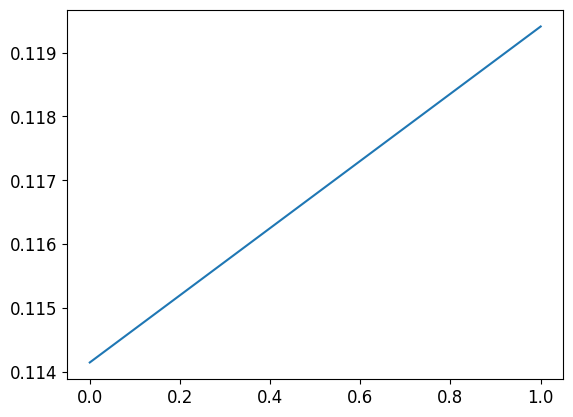

In [86]:
acc_arr = np.stack([metrics_history[s]['test_accuracy'] for s in seeds], axis=0)
plt.plot(acc_arr.mean(0))
plt.fill_between(range(acc_arr.shape[1]), acc_arr.mean(0) - acc_arr.std(0), acc_arr.mean(0) + acc_arr.std(0), alpha=0.3)


# np.save('ANIL_results/results_fo.npy', acc_arr)
# np.save(f'ANIL_results/results_proposed_{gamma}.npy', acc_arr)
# np.save(f'ANIL_results/results_DrMAD.npy', acc_arr)

# ??? why no test loss???
acc_arr.max(-1)